# Test Model

Each green square is roughly 260m x 260m or about 2.5 times the length of a soccer of football field

<img src="assets/TestModel.jpg" width="500"/>

Even though this model was trained on images and data from **New Mexico** it predicts very well in Utah

The red circled building is the famous **Dinosaur National Monument** building housing the bones still being excavated from the site.

The site was discovered in 1909 by paleontologist Earl Douglass of the Carnegie Museum 

<img src="assets/DNM_Camarasaurus.jpg" width="500"/>

Essentially, the **New Mexico** trained model, predicts **bone likely** at the site of this building in **Utah**!

This is based on the texture and color of the depositional environments of sandstones and claystone’s of the Brushy Basin member of the Morrison Formation


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import json
import glob
import os

# Indicate what backbone model was used
scratch_model = models.resnet18(pretrained=True)
num_ftrs = scratch_model.fc.in_features
# modify the backbone to have just three predicted classes
classes = 3
scratch_model.fc = nn.Linear(num_ftrs, classes)
scratch_model.load_state_dict(torch.load('models/resnet18-Gold20220530.pt'))

#indicate the path and filename of output image
map_save = 'data/MoabDinoTrail_ThreeClassBalanced.jpg'

# Data augmentation and normalization for training
# Just normalization for validation
input_size = 224
data_dir = "data/ThreeClassManualRemove0s/"

batch_size = 64
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cpu")
print("device: {}".format(device))


files = []
class_true = []
class_pred = []
#my_classes = ['Bone', 'NoBone']
my_classes = image_datasets['val'].classes

green = Image.new('RGBA',(224,224),(0,255,0,60))
white = Image.new('RGBA',(224,224),(255,255,255,1))
lightGreen = Image.new('RGBA',(224,224),(0,255,0,20))
black = Image.new('RGBA',(224,224),(0,0,0,1))


def DatasetSizes(dataset_ReadClassChoices):
    dataset_sizes = {x: len(dataset_ReadClassChoices[x]) for x in ['train', 'val']}
    return dataset_sizes

def scoreSingleImage(ImagePath, model, dataset_classes):
    from PIL import Image
    import torch.nn.functional as F
    from torch.autograd import Variable
    model.eval()
    #model.to(device)
    img = Image.open(ImagePath).convert('RGB') 
    x_test = data_transforms['val'](img)[:3]   #3 channels in case png bobc
    x_test.unsqueeze_(0)  # Add batch dimension
    x_test2 = Variable(x_test)
    output = model(x_test)
    class_names = dataset_classes
    predArgmax = torch.argmax(output[0]).numpy()
    confidence = F.softmax(output, dim=0)
    score = []
    score.append( class_names[predArgmax] )
    score.append( float(confidence[0][predArgmax]) )
    return score 



Initializing Datasets and Dataloaders...
device: cpu


In [2]:
filename = 'data/ThreeClassManualRemove0s/train/2/Batwing07.png'
scoreSingleImage(filename, scratch_model, my_classes)

['2', 1.0]

# Score val folder to print metrics

### Metrics Utilities

In [3]:
# for Violence Class
def calc_metrics(tp_rowcol, cm):
    # this works only for col 0, row 0 for now 
    #will troubleshoot other columns later
    # so its works for Violence but i have not generalized the cal to accomdate other row,col as the tp

    tmp = 0
    tp_rowcol = -tp_rowcol
    tmp = np.roll(cm, tp_rowcol, axis=1)
    cm = np.roll(tmp, tp_rowcol, axis=0)  

    L = len(cm)
    tp = cm[0][0]
    fn = sum(cm[0][1:L])
    fp = sum(cm, axis = 0)[0] - tp
    ftn = sum(cm, axis = 0) - cm[0]
    tn = sum(cm[1:L,1:L])
    sensitivity_recall =  tp  / (tp + fn + 0.)
    specificity =  tn / (tn + fp + 0.)
    precision =  tp / (tp + fp + 0.)
    accuracy =  (tp+tn+ 0.)/(tp+fp+fn+tn + 0.)
    f1 = 2.0*precision*sensitivity_recall/(precision+sensitivity_recall)
    return(accuracy, precision, sensitivity_recall, specificity, f1)
def print_metrics(accuracy, precision, sensitivity_recall, specificity, f1):
    print ('accuracy: ', accuracy)
    print ('sensitivity_recall: ',sensitivity_recall)
    print ('specificity: ', specificity)
    print ('precision: ', precision)
    print ('f1: ', f1)
def metricsAsDataframe(accuracy, precision, sensitivity_recall, specificity, f1):
    data = [{'metric': 'accuracy', 'Value': accuracy, 'Description': '(tp+tn)/(tp+fp+fn+tn)'},
             {'metric': 'precision',  'Value': precision, 'Description': 'tp/(tp+fp)' },
             {'metric': 'sensitivity_recall',  'Value': sensitivity_recall, 'Description': 'tp  / (tp + fn)'},
             {'metric': 'specificity',  'Value': specificity,  'Description': 'tn / (tn + fp)'},
            {'metric': 'F1',  'Value': f1,  'Description': '2*precision*recall/(precision+recall)'}]
    dfObj = pd.DataFrame(data, columns=['metric', 'Value', 'Description'])
    return dfObj

# Score All Validation Images

In [5]:
import json
import glob
import os

folders = my_classes
files = []
class_true = []
class_pred = []
for fl in folders:
    path = data_dir + 'val/' + fl + '/'
    for filename in glob.glob(os.path.join(path, '*.png')):
        files.append(filename)
        try: 
            pred = scoreSingleImage(filename, scratch_model, my_classes)
            class_pred.append(pred[0])
            class_true.append(filename.split('/')[-2])
        except:
            print ("File not compatible (channels)", filename)
        
#[[t, p] for t, p in zip(class_true, class_pred)]

# Print Confusion Matrix

In [6]:
%matplotlib inline
import matplotlib as plt
from matplotlib import *
import sys
from pylab import *
from sklearn.metrics import confusion_matrix

y_true = class_true
y_pred = class_pred

myset = set(y_true)
labels = list(myset)

cm = confusion_matrix(y_true, y_pred,  labels=labels)
cmd = cm.copy()
print(cmd)

[[231   0   0]
 [  0 210  29]
 [  0  12 329]]


In [ ]:
print(100*np.round(cmd/cmd.sum(), 3))

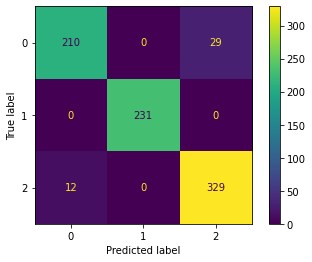

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

class_true = np.array(class_true)
class_pred = np.array(class_pred)
ConfusionMatrixDisplay.from_predictions(class_true, class_pred)
plt.show()

If you have any issues or want to contribute, please contact our authors:
Intel oneAPI Solution Architect
- Chesebrough, Bob [bob.chesebrough (at) intel.com]

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 